# Automating data quality monitoring - Constraints Distributional Measures

Suppose you are training a model to predict whether a loan for a certain member of LendingClub will be accepted or not.

Here we have sampled 1000 members' data to illustrate how the constraints can be used to automatically enforce data quality.

When training an ML model and deploying it in production, sometimes we notice a significant performance degradation. That can often be a consequence of drift in the data that we used for training the model, and the data that needs to be predicted in some batch while the model runs in production.

'Distributional Measures Constraints' can be used to make data quality checks in a data pipeline automatically. In some cases it's too expensive to perform manual inspection of incoming data every time, so automated checks save a lot of time and effort in these situations. If some of the defined constraints fail, then we might need to take some action before passing the data to the model for prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from whylogs import get_or_create_session
from whylogs.util.protobuf import message_to_json
from whylogs.core.statistics.constraints import DatasetConstraints
import warnings
warnings.filterwarnings('ignore')

# create session
session = get_or_create_session()

WARN: Missing config


'format_report' is a utility function for displaying more human-readable constraints reports

In [3]:
from tabulate import tabulate

def indent(txt, spaces=6):
    return "\n".join(" " * spaces + ln for ln in txt.splitlines())

def format_report(r):
    # report failures in tabular form
    
    r_2 = [entry for entry in r if len(entry)==2] # all the single column constraints
    
    if len(r_2):
        print("Constraint failures by feature")
    for c,r in r_2:
        print(f"{c}:")
        if len(r[0][0]) > 80: 
            print(f"\ntest_name:\t{r[0][0]}\n")
            print(f"total_run:\t{r[0][1]}\n")
            print(f"failed:\t\t{r[0][2]}\n")
        else:    
            print(indent(tabulate(r, tablefmt="plain", headers=['test_name', 'total_run', 'failed'])))

Read the data for the example. The data contains features about 1000 LendingClub members.

In [4]:
data = pd.read_csv('data/lending_club_1000.csv')
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,90671227,NaN,4800.0,4800.0,4800.0,36 months,13.49,162.87,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,90060135,NaN,21600.0,21600.0,21600.0,60 months,9.49,453.54,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,90501423,NaN,24200.0,24200.0,24200.0,36 months,9.49,775.09,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,90186302,NaN,3600.0,3600.0,3600.0,36 months,11.49,118.70,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,90805192,NaN,8000.0,8000.0,8000.0,36 months,10.49,259.99,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# remove whitespace characters from the feature 'term'
data.loc[:, 'term'] = [str.strip(term) if not isinstance(term, float) else term for term in data['term'].values]

Let's suppose that the first 80% of the data (800 columns) were used for training the ML model, and the last 20% of the data is a new unseen batch of data that needs to used to make a prediction.

In [6]:
# split the data according to the hypothetic situation
data_train = data.iloc[:800, :]
data_test = data.iloc[800:, :]

We present some simple and efficient ways to check for data quality and drift.

In [7]:
def show_feature_bar_chart_in_train_and_test_data(feature, training_data, testing_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(f'Distribution of the feature "{feature}"')
    training_data[feature].value_counts().plot.bar(ax=ax1)
    ax1.set_title("Training data set")
    testing_data[feature].value_counts().plot.bar(ax=ax2)
    ax2.set_title("Testing data set")
    plt.show()

In [8]:
def show_feature_histogram_in_train_and_test_data(feature, training_data, testing_data, bins=20):
    plt.figure(figsize=(10, 5))
    sns.histplot(training_data[feature], bins=bins, kde=True, ax=plt.gca(), label='Training data set')
    sns.histplot(testing_data[feature], bins=bins, kde=True, ax=plt.gca(), label='Testing data set', color='red')
    plt.title(f'Distribution of the feature "{feature}"')
    plt.legend()
    plt.show()

## Distributional Measure: Chi-Squared test p-value

To compare two discrete distributions, we can use the Chi-Squared test, or the KL-Divergence. We first illustrate how to use the 'columnChiSquaredTestPValueGreaterThanConstraint' which defines a constraint on the Chi-Squared test's p-value, to be greater than some value (default is 0.05)

In [9]:
from whylogs.core.statistics.constraints import columnChiSquaredTestPValueGreaterThanConstraint

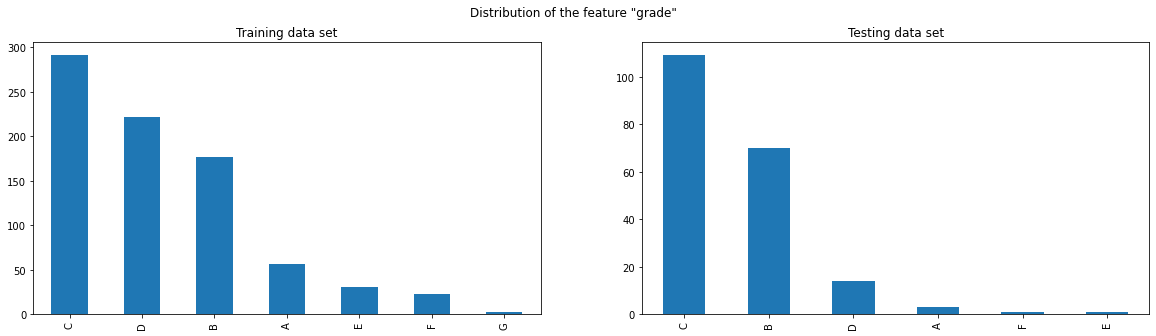

In [10]:
show_feature_bar_chart_in_train_and_test_data('grade', data_train, data_test)

From the bar charts, we can see that there is some difference in the distribution of the feaure "grade" in the training and testing data set. But this visual inspection does not provide the statistical difference between the distribution and can't be used when implementing data checks automatically.

We are going to define a 'columnChiSquaredTestPValueGreaterThanConstraint' constraint which will use the values of the feature 'grade' from the training data set as a reference distribution, and we will set the p-value to 0.05.

This constraint can then be applied when logging the test data set, so that we can check if the new distribution of the feature 'grade' in the test data set successfully passes the constraint for the Chi-Squared test p-value to be greater than 0.05, with reference to the distribution of the same feature in the training data set. If so, then this means that the two features likely come from the same distribution.

In [11]:
# define Chi-Squared test p-value greater than constraint
grade_chi_squared_p_value_greater_than = columnChiSquaredTestPValueGreaterThanConstraint(
    reference_distribution = data_train['grade'].values,
    p_value=0.05
)

## Distributiona Measure: KL-Divergence

### KL-Divergence constraint: Discrete distribution

Another constraint that can be used to detect data drift is the KL-Divergence constraint. This constraint can be applied to two discrete or two continuous distributions. In this subsection we illustrate both cases.

In [12]:
from whylogs.core.statistics.constraints import columnKLDivergenceLessThanConstraint

Let's plot the distribution of the feature 'term'. From the bar charts we can see that the frequency of the two categories of the feautre '36 months' and '60 months' have drastically changed in the testing data set, compared to the training data set.

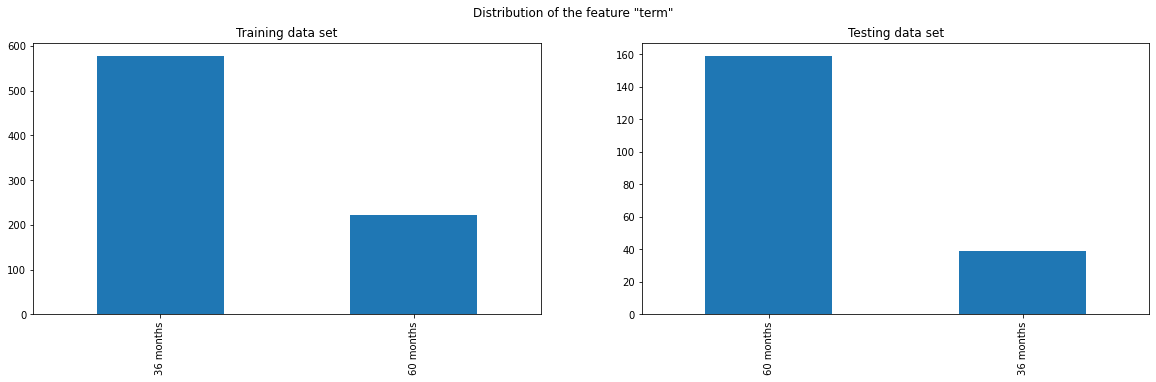

In [13]:
show_feature_bar_chart_in_train_and_test_data('term', data_train, data_test)

To check this in a data pipeline, we can define a 'columnKLDivergenceLessThanConstraint' using the values of the feature 'term' from the training data set as a reference distribution. We also need to define some threshold, above which we can consider the drift to be significant. In this case, let's assume that we did some research and came to the conclusion that the optimal threshold value is 0.5.

In [14]:
term_kl_divergence_less_than = columnKLDivergenceLessThanConstraint(
    reference_distribution = data_train['term'].values, 
    threshold = 0.5
)

### KL Divergence constraint - continuous distribution

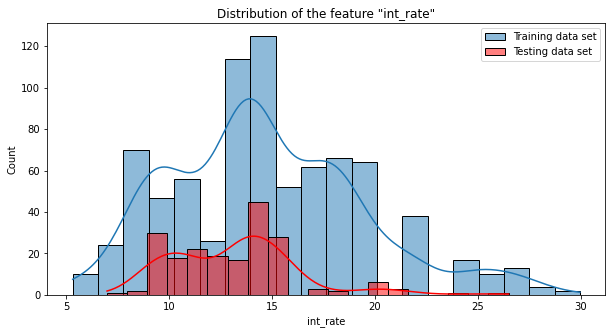

In [15]:
show_feature_histogram_in_train_and_test_data('int_rate', data_train, data_test)

From this figure we can see that tthe distribution of the feature 'int_rate' in the training and the testing data set is somewhat similar.

We can define a KL-Divergence constraint in the same way for continuous distributions, as for discrete. First, we specify that the reference distribution is the values of 'int_rate' in the training data set, and with some careful consideration (hypothetically), we have calculated that the drift should be identified as significant if it the KL-Divergence is larger than 2.5.

In [16]:
int_rate_kl_divergence_less_than = columnKLDivergenceLessThanConstraint(
    reference_distribution = data_train['int_rate'].values,
    threshold = 2.5,
)

# Distributional Measures: KS test p-value

Just like we had the Chi-Squared test p-value constraint for discrete features, we also have the KS test p-value constraint, which can be applied to test if two continuous features come from the same distribution.

This is another constraint that can be used, instead of the KL-Divergence for continuous distributions. You are free to choose whichever suits your use case best.

In [17]:
from whylogs.core.statistics.constraints import parametrizedKSTestPValueGreaterThanConstraint

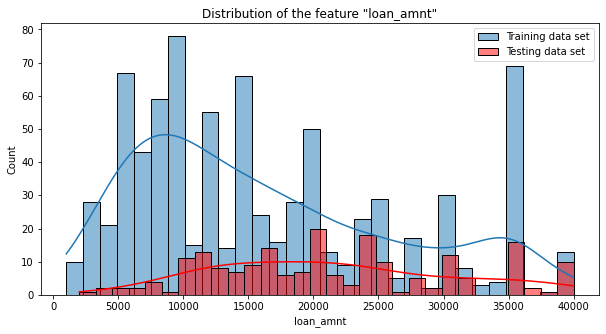

In [18]:
show_feature_histogram_in_train_and_test_data('loan_amnt', data_train, data_test, bins=30)

The distributions of 'loan_amnt' seems a bit different in both data sets.

We can define the 'parametrizedKSTestPValueGreaterThanConstraint' in a similar way to all of the other distributional measures constraints. We set the reference_distribution to be equal to the values of the feature 'loan_amnt' in the training data set, and we set the p-value to 0.05.

In [19]:
loan_amnt_ks_test_p_value_greater_than = parametrizedKSTestPValueGreaterThanConstraint(
    reference_distribution = data_train['loan_amnt'].values,
    p_value = 0.05,
)

# Single Feature Distributional Measure: Entropy

Another use-case we might be interested in is deciding which features provide value, or don't have a large amount of uncertanity within their values. For these reason we can use the 'approximateEntropyBetweenConstraint'.

In [20]:
from whylogs.core.statistics.constraints import approximateEntropyBetweenConstraint

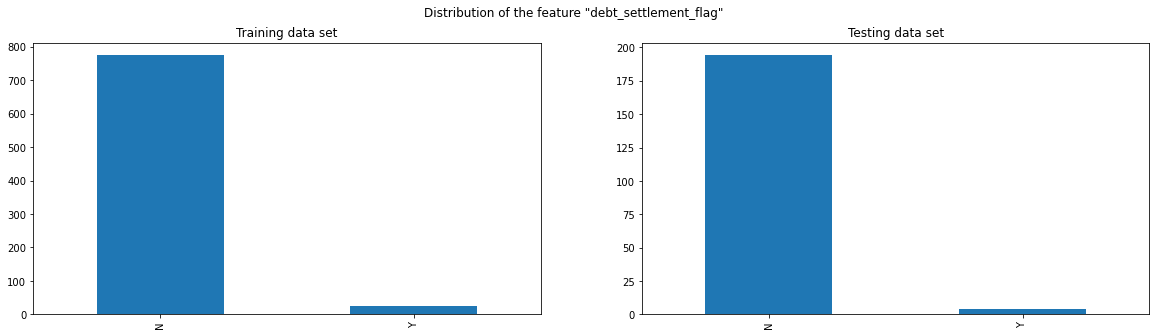

In [21]:
show_feature_bar_chart_in_train_and_test_data('debt_settlement_flag', data_train, data_test)

Here we see that the distribution of the feature 'debt_settlement_flag' is very similar in both data sets.

To define the constraint, we can calculate the entropy on the training data, or take some apriori value for the entropy which we believe is the groud truth, and then define the bounds within which we expect this value to vary in the data sets.

We define the 'approximateEntropyBetweenConstraint' by specifying the lower and upper values of the interval of valid entropy. In this case we have chosen some reference value 0.15 and we define the bounds to be in the range (0.15-0.05, 0.15+0.05).

In [22]:
debt_settlement_flag_approx_entropy_between = approximateEntropyBetweenConstraint(
    lower_value = 0.1,
    upper_value = 0.20,
)

We have now defined all of the constraints we are interested in. To apply them to a data set, we first create a DataSetConstraints object. This object has arguments for 'value_constraints', 'summary_constraints', 'table_shape_constraints', and 'multi_column_value_constraints'. Since the distributional measures are all of type 'SummaryConstraint' we will only set the 'summary_constraints' argument.

We pass a dictionary with keys equalt to the featre names, and a value equal to the list of constraints we want to apply to that feature. The first argument in the initialization is a properties object, but we do not need to set it explicitly.

In [23]:
constraints = DatasetConstraints(
    None,
    summary_constraints = {
        "grade": [grade_chi_squared_p_value_greater_than],
        "term": [term_kl_divergence_less_than],
        "int_rate": [int_rate_kl_divergence_less_than],
        "loan_amnt": [loan_amnt_ks_test_p_value_greater_than],
        "debt_settlement_flag": [debt_settlement_flag_approx_entropy_between]
    }
)

After we have defined the constraints we can log the dataframe of choice together with the constraints.

We are first going to log the 'data_train' dataframe, to show that all of the constraints will pass without failures, since all of the reference distributions correspond to the data in this dataframe.

In [24]:
profile = session.log_dataframe(data_train, "test.data", constraints=constraints)

In [25]:
report = profile.apply_summary_constraints()
format_report(report)

Constraint failures by feature
grade:
      test_name                                        total_run    failed
      Chi-Squared test p-value is greater than 0.05            1         0
term:
      test_name                         total_run    failed
      KL Divergence is less than 0.5            1         0
int_rate:
      test_name                         total_run    failed
      KL Divergence is less than 2.5            1         0
loan_amnt:
      test_name                                            total_run    failed
      parametrized KS test p-value is greater than 0.05            1         0
debt_settlement_flag:
      test_name                                     total_run    failed
      approximate entropy is between 0.1 and 0.2            1         0


The result represents the report generated from the applied constraints. We can see that there are no failures in the constraints for the training data set.

Now, what really interests us is how the constraints behave on the new unseen data that our model needs to use for prediction.

If we log the testing data set with the constraints and then apply them, we can see that some constraints have failed.

In [26]:
test_profile = session.log_dataframe(data_test, "test.data", constraints=constraints)

In [27]:
test_report = test_profile.apply_summary_constraints()
format_report(test_report)

Constraint failures by feature
grade:
      test_name                                        total_run    failed
      Chi-Squared test p-value is greater than 0.05            2         0
term:
      test_name                         total_run    failed
      KL Divergence is less than 0.5            2         1
int_rate:
      test_name                         total_run    failed
      KL Divergence is less than 2.5            2         0
loan_amnt:
      test_name                                            total_run    failed
      parametrized KS test p-value is greater than 0.05            2         1
debt_settlement_flag:
      test_name                                     total_run    failed
      approximate entropy is between 0.1 and 0.2            2         0


According to this report, we have a failure in the features 'term' and 'loan_amnt' for which we saw that the distributions were different in the two data sets. The outcomes of the constraints signify that there is a high drift for these features in the new data set.

You can further automate the process of data quality checks by defining some behaviour in case a constraint fails, such as in the cases show in this example notebook.